In [148]:
import numpy as np
import pandas as pd
import glob
import os
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, MinMaxScaler


## Get Base Datasets

In [410]:
df = pd.read_csv(r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Redfin Data\rentals.csv")

# single_family_home_rentals = all_rentals[(all_rentals["Property Type"] == 6) & (all_rentals["Max Beds"] < 5) & (all_rentals["State"]).isin(["WA", "OR"])]

df = df[(df["Max Beds"] > 0 ) 
        & (df["Max Beds"] < 6)  
        & (df["Max Baths"] < 4)  
        & (df["Max Square Feet"] < 5000)  
        & (df["Max Rent Price"] < 10000)  
        & (df["State"].notna()) 
        & (df["Property Type"] == 6) 
        # & (df["State"]).isin(["TX"])
        ]

# df = df[~df['Address'].str.contains('Unit', case=False, na=False) & 
#         ~df['Address'].str.contains('Apt', case=False, na=False)]

df = df.rename(columns={
    'Max Square Feet': 'Square Feet',
    'Max Beds': 'Bedrooms',
    'Max Baths': 'Bathrooms',
    'Max Rent Price': 'Rent',
})

basic_metadata = ["Property ID", "Address"]

basic_features = ["Square Feet", "Bedrooms", "Bathrooms"]
target = "Rent"


## Get Median Income Dataset

In [416]:
#Get Median Income Data
median_income = pd.read_csv(r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Rent Training Data\ACSDT5Y2022.B19013-Data.csv", skiprows=[1], na_values='-')

median_income['GEO_ID'] = median_income['GEO_ID'].astype(str)

# Extracting everything after "US" and storing it in a new column 'cbg_geoid'
median_income['cbg_geoid'] = median_income['GEO_ID'].str.extract('US(\d+)')
median_income['median_income'] = median_income['B19013_001E'].str.replace(',','+').str.replace('+','').str.replace('-','').astype(float)

median_income = median_income[["cbg_geoid", "median_income" ]]

print(df["Property ID"].count())

df["cbg_geoid"] = df["cbg_geoid"].astype(str).str.split('.').str[0]
median_income["cbg_geoid"] = median_income["cbg_geoid"].astype(str)

df = df.merge(median_income, on='cbg_geoid', how="inner")

print(df["Property ID"].count())

23651
23650


## Get Demographics Dataset

In [504]:
def format_tractce(tract):
    tract_str = str(tract)
    if len(tract_str) == 3:
        return '000' + tract_str #+ '00'
    elif len(tract_str) == 4:
        return '00' + tract_str
    elif len(tract_str) == 5:
        return '0' + tract_str
    elif len(tract_str) == 6:
        return tract_str
    else:
        return tract_str  # In case of unexpected length


epa_cbg_demo = pd.read_csv(r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Rent Training Data\EPA_SmartLocationDatabase_V3_Jan_2021_Final (1).csv")


# Apply the formatting function to TRACTCE
epa_cbg_demo["TRACTCE_FORMATTED"] = epa_cbg_demo["TRACTCE"].apply(format_tractce) 

# epa_cbg_demo["TRACT_FIPS_SIMPLE"] = epa_cbg_demo['TRACTCE'].apply(format_tractce).str[:-2] + '00'


epa_cbg_demo["cbg_geoid"] = \
    epa_cbg_demo["STATEFP"].astype(str).str.zfill(2)  \
    + epa_cbg_demo["COUNTYFP"].astype(str).str.zfill(3) \
    + epa_cbg_demo["TRACTCE_FORMATTED"].astype(str) \
    + epa_cbg_demo["BLKGRPCE"].astype(str)

epa_cbg_demo['cbg_geoid'].astype(str).str.len().value_counts()


df["cbg_geoid"] = df["cbg_geoid"].astype(str)


test = df.merge(epa_cbg_demo, on='cbg_geoid', how="left")

test["TRACTCE_LEN"] = test["TRACTCE"].astype(str).str.len() -2

display(test[["cbg_geoid","STATEFP", "COUNTYFP","TRACTCE","TRACTCE_FORMATTED", "TRACTCE_LEN"]])

display(test["TRACTCE"].count())

,cbg_geoid,STATEFP,COUNTYFP,TRACTCE,TRACTCE_FORMATTED,TRACTCE_LEN
0,160050015003,16.0,5.0,1500.0,001500,4
1,160050015003,16.0,5.0,1500.0,001500,4
2,160050015003,16.0,5.0,1500.0,001500,4
3,160050015003,16.0,5.0,1500.0,001500,4
4,160050015003,16.0,5.0,1500.0,001500,4
...,...,...,...,...,...,...
23645,482599703021,48.0,259.0,970302.0,970302,6
23646,482599704032,NaN,NaN,NaN,NaN,1
23647,480291821022,48.0,29.0,182102.0,182102,6
23648,480291821022,48.0,29.0,182102.0,182102,6


12656

In [485]:
display(epa_cbg_demo["cbg_geoid"].count())

display(epa_cbg_demo["cbg_geoid"].nunique())

220740

220740

In [490]:
print(df["cbg_geoid"].nunique())

print(median_income["cbg_geoid"].nunique())

# print(cbg_demographics["cbg_geoid"].nunique())

print("NaNs in median_income 'cbg_geoid':", median_income['cbg_geoid'].isna().sum())
print("NaNs in epa_cbg_demo 'cbg_geoid':", epa_cbg_demo['cbg_geoid'].isna().sum())

median_income['cbg_geoid_length'] = median_income['cbg_geoid'].str.len()
epa_cbg_demo['cbg_geoid_length'] = epa_cbg_demo['cbg_geoid'].str.len()

print(median_income['cbg_geoid_length'].value_counts())
print(epa_cbg_demo['cbg_geoid_length'].value_counts())



10385
242336
NaNs in median_income 'cbg_geoid': 0
NaNs in epa_cbg_demo 'cbg_geoid': 0
cbg_geoid_length
12    242336
Name: count, dtype: int64
cbg_geoid_length
12    220740
Name: count, dtype: int64


In [391]:
# Find `cbg_geoid` values in `median_income` that are not in `epa_cbg_demo`
median_income_only = set(median_income['cbg_geoid']) - set(epa_cbg_demo['cbg_geoid'])
print(f"Number of `cbg_geoid` values in `median_income` not in `epa_cbg_demo`: {len(median_income_only)}")
print("Examples of `cbg_geoid` values in `median_income` not in `epa_cbg_demo`:", list(median_income_only)[:10])

# Find `cbg_geoid` values in `epa_cbg_demo` that are not in `median_income`
epa_cbg_demo_only = set(epa_cbg_demo['cbg_geoid']) - set(median_income['cbg_geoid'])
print(f"Number of `cbg_geoid` values in `epa_cbg_demo` not in `median_income`: {len(epa_cbg_demo_only)}")
print("Examples of `cbg_geoid` values in `epa_cbg_demo` not in `median_income`:", list(epa_cbg_demo_only)[:10])


Number of `cbg_geoid` values in `median_income` not in `epa_cbg_demo`: 100672
Examples of `cbg_geoid` values in `median_income` not in `epa_cbg_demo`: ['390170103003', '530090014002', '212270103003', '517600111003', '390070009004', '551170005001', '483750126002', '410470023001', '360850040001', '050310009003']
Number of `cbg_geoid` values in `epa_cbg_demo` not in `median_income`: 167008
Examples of `cbg_geoid` values in `epa_cbg_demo` not in `median_income`: ['060014501021', '060773405002', '330099610004', '25025601011', '36047387002', '020201200004', '170438461021', '53033227022', '27037608211', '170370300002']


In [356]:
df["cbg_geoid"] = df["cbg_geoid"].fillna(-1).astype('int64').astype(str)

demo_corr_test_df = pd.merge(df[["Property ID", "cbg_geoid", "Rent"]], cbg_demographics, on='cbg_geoid', how='inner', suffixes=('_rental', '_demo'))



12656

## Get All potential Demographic Features.

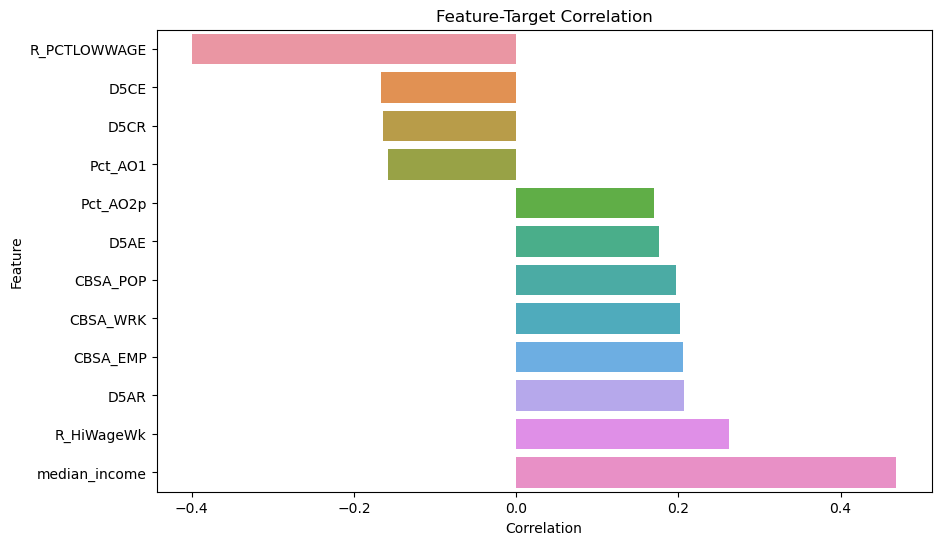

In [154]:
# Ensure 'target' is a string and it exists in your DataFrame
if target not in demo_corr_test_df.columns:
    raise ValueError(f"Target column '{target}' does not exist in the DataFrame")

# Select numeric columns
demo_basic_features = demo_corr_test_df.select_dtypes(include=["number"]).columns.tolist()

demo_basic_features = [feature for feature in demo_basic_features if "id" not in feature.lower()]

if 'Rent' in demo_basic_features:
    demo_basic_features.remove('Rent')


# Remove rows with NaN values in any of the selected columns or the target column
demo_corr_test_df_clean = demo_corr_test_df[demo_basic_features + [target]].dropna()

# Calculate correlations
feature_target_correlation = pd.DataFrame({
    "feature": demo_basic_features,
    "correlation": demo_corr_test_df_clean[demo_basic_features].corrwith(demo_corr_test_df_clean[target])
})

# Reset index to turn the index into a column
feature_target_correlation.reset_index(drop=True, inplace=True)

# Filter correlations with an absolute value greater than 0.15
correlation_to_plot = feature_target_correlation[abs(feature_target_correlation["correlation"]) > .15]

# Create the bar chart using Seaborn
plt.figure(figsize=(10, 6))  # Set the size of the figure
sns.barplot(x="correlation", y="feature", data=correlation_to_plot.sort_values("correlation"))

# Add titles and labels
plt.title('Feature-Target Correlation')
plt.xlabel('Correlation')
plt.ylabel('Feature')

# Display the plot
plt.show()

# Extract features with correlation greater than 0.15
potential_demographic_features = correlation_to_plot["feature"].tolist()

cbg_demographics["cbg_geoid"] = cbg_demographics["cbg_geoid"].fillna(-1).astype('int64').astype(str)


# Merge dataframes on 'cbg_geoid'
df = pd.merge(df, cbg_demographics[potential_demographic_features + ["cbg_geoid"]], on='cbg_geoid', how='left', suffixes=('_rental', '_demo'))



## One Hot for Beds and Baths

In [155]:
columns_to_encode = ['Bedrooms', 'Bathrooms']

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid dummy variable trap

# Fit and transform the data
encoded_features = encoder.fit_transform(df[columns_to_encode])

# Get feature names for the encoded columns
encoded_feature_names = encoder.get_feature_names_out(columns_to_encode)

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Concatenate the original DataFrame (excluding the original columns) with the encoded DataFrame
df = pd.concat([df, encoded_df], axis=1)

one_hot_features = encoded_feature_names.tolist()

## KNN Benchmark

In [238]:
knn_features = ["Latitude", "Longitude"]
target = 'Rent'

# List of different n values
n_values = [1, 5, 10]

# Convert latitude and longitude from degrees to radians for haversine metric
df_rad = np.radians(df[knn_features].values)

# Loop over different values of n
for n in n_values:
    # Create a new column for the benchmark rent for each n
    column_name = f'Rent_Benchmark_{n}_neighbors'
    df[column_name] = np.nan
    
    # Drop rows with missing values in the knn_features or target columns
    knn_df = df[knn_features + [target]].dropna()
    
    # Extract feature values and target values
    X = knn_df[knn_features].values
    y = knn_df[target].values
    
    # Convert latitude and longitude from degrees to radians for haversine metric
    X_rad = np.radians(X)
    
    # Initialize the KNeighborsRegressor with the haversine metric
    knn = KNeighborsRegressor(n_neighbors=n, metric='haversine')
    
    # Fit the KNN model
    knn.fit(X_rad, y)
    
    # Predict the average rent for each point in the original DataFrame
    df[column_name] = knn.predict(df_rad)

# Display the first few rows of the DataFrame with the new columns
benchmark_features = [f'Rent_Benchmark_{n}_neighbors' for n in n_values]

display(df[benchmark_features].head())

,Rent_Benchmark_1_neighbors,Rent_Benchmark_5_neighbors,Rent_Benchmark_10_neighbors
0,1000.0,1025.0,1305.0
1,1050.0,1030.0,1305.0
2,850.0,1235.0,1492.4
3,1450.0,1410.0,1534.9
4,795.0,1523.0,1255.5


## Rescale Features

In [322]:
potential_features = potential_demographic_features + one_hot_features + basic_features + benchmark_features

clean_df = df[basic_metadata + potential_features + [target]].dropna()

# display(clean_df)
# display(potential_features)

X_train, X_test, y_train, y_test = train_test_split(clean_df[potential_features], clean_df[[target]], train_size = .8, random_state=27)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.fit_transform(X_test)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

## Can we add Polynominals and Interactions

In [323]:
# only going to to leads to 324 Features. Up another level goes farther to like 9K
poly = PolynomialFeatures(degree = 2, include_bias=False)

X_train_poly = poly.fit_transform(X_train_scaled)

X_test_poly = poly.transform(X_test_scaled)

print("X_Train.shape: {}".format(X_train_scaled.shape))

print("X_Train_poly.shape: {}".format(X_train_poly.shape))


X_Train.shape: (9720, 27)
X_Train_poly.shape: (9720, 405)


In [324]:
from sklearn.linear_model import Ridge, Lasso 
from sklearn.ensemble import RandomForestRegressor

lr = LinearRegression().fit(X_train_scaled, y_train)
print("Linear Regression Score without Interations: {}".format(lr.score(X_test_scaled, y_test)))

lr_interactions = LinearRegression().fit(X_train_poly, y_train)
print("Linear Regression Score with Interations: {}".format(lr_interactions.score(X_test_poly, y_test)))

ridge = Ridge().fit(X_train_scaled, y_train)
print("Ridge Score without Interations: {}".format(ridge.score(X_test_scaled, y_test)))

ridge_interactions = Ridge().fit(X_train_poly, y_train)
print("Ridge Score with Interations: {}".format(ridge_interactions.score(X_test_poly, y_test)))

lasso = Lasso().fit(X_train_scaled, y_train)
print("Lasso Score without Interactions: {}".format(lasso.score(X_test_scaled, y_test)))

lasso_interactions = Lasso().fit(X_train_poly, y_train)
print("Lasso Score with Interations: {}".format(lasso_interactions.score(X_test_poly, y_test)))

#Too Slow
# rf = RandomForestRegressor().fit(X_train_scaled, y_train)
# print("Random Forrest Score without Interactions: {}".format(rf.score(X_test_scaled, y_test)))

# Too Slow
# rf_int = RandomForestRegressor(n_estimators=100).fit(X_train_poly, y_train)
# print("Random Forrest Score with Interations: {}".format(rf_int.score(X_test_poly, y_test)))


Linear Regression Score without Interations: 0.9385966439203932
Linear Regression Score with Interations: 0.9561598520268249
Ridge Score without Interations: 0.9392996051058078
Ridge Score with Interations: 0.9581751023250529
Lasso Score without Interactions: 0.9352957424886834
Lasso Score with Interations: 0.9460305657412122


## Explore Ridge With Interactions More

In [294]:
ridge_interactions = Ridge().fit(X_train_poly, y_train)


y_train_pred = ridge_interactions.predict(X_train_poly)

y_test_pred = ridge_interactions.predict(X_test_poly)

X_combined = pd.concat([X_train, X_test])
y_combined_pred = np.concatenate([y_train_pred, y_test_pred])
train_flag_combined = np.concatenate([np.ones(len(X_train)), np.zeros(len(X_test))])



163.24393813563793
0.9581751023250529


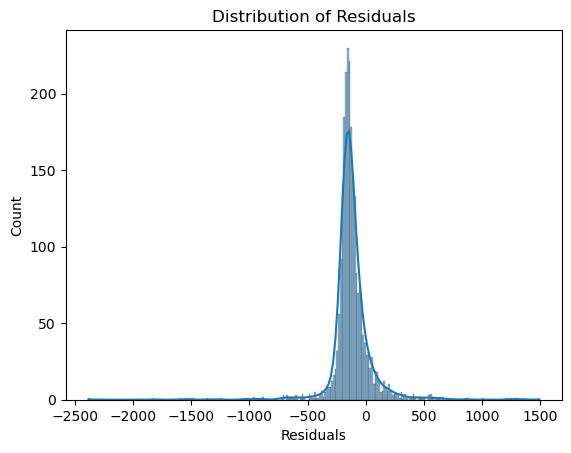

In [295]:
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(mae)
print(r2)

residuals = y_test_pred - y_test

sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()


## Feature Selection with Recursive Feature Eliminiation with Cross Val

In [312]:
from sklearn.feature_selection import RFECV

ridge = Ridge()

# Initialize RFECV with the Ridge model
rfecv = RFECV(estimator=ridge, step=1, cv=5, scoring='r2')

# Fit RFECV
rfecv.fit(X_train_poly, y_train)

# Number of features selected
print("Optimal number of features: %d" % rfecv.n_features_)


Optimal number of features: 133


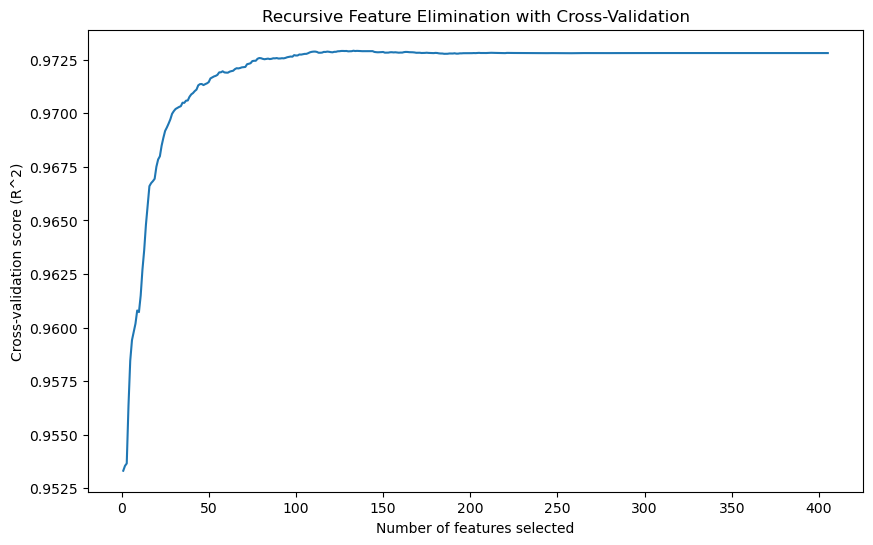

Selected features: ['CBSA_POP', 'CBSA_WRK', 'Pct_AO1', 'Pct_AO2p', 'R_PCTLOWWAGE', 'D5AE', 'D5CE', 'median_income', 'Bathrooms_2.5', 'Square Feet', 'Bedrooms', 'Bathrooms', 'Rent_Benchmark_1_neighbors', 'Rent_Benchmark_5_neighbors', 'Rent_Benchmark_10_neighbors', 'CBSA_POP CBSA_WRK', 'CBSA_POP R_HiWageWk', 'CBSA_POP R_PCTLOWWAGE', 'CBSA_POP D5AR', 'CBSA_POP median_income', 'CBSA_POP Rent_Benchmark_1_neighbors', 'CBSA_POP Rent_Benchmark_5_neighbors', 'CBSA_EMP^2', 'CBSA_EMP Rent_Benchmark_1_neighbors', 'CBSA_EMP Rent_Benchmark_10_neighbors', 'CBSA_WRK^2', 'CBSA_WRK Pct_AO2p', 'CBSA_WRK D5AR', 'CBSA_WRK Rent_Benchmark_1_neighbors', 'CBSA_WRK Rent_Benchmark_5_neighbors', 'Pct_AO1 Pct_AO2p', 'Pct_AO1 R_HiWageWk', 'Pct_AO1 R_PCTLOWWAGE', 'Pct_AO1 D5AE', 'Pct_AO1 Bathrooms_2.5', 'Pct_AO1 Bedrooms', 'Pct_AO1 Bathrooms', 'Pct_AO1 Rent_Benchmark_1_neighbors', 'Pct_AO1 Rent_Benchmark_5_neighbors', 'Pct_AO2p^2', 'Pct_AO2p R_HiWageWk', 'Pct_AO2p R_PCTLOWWAGE', 'Pct_AO2p D5AR', 'Pct_AO2p D5AE', 'Pc

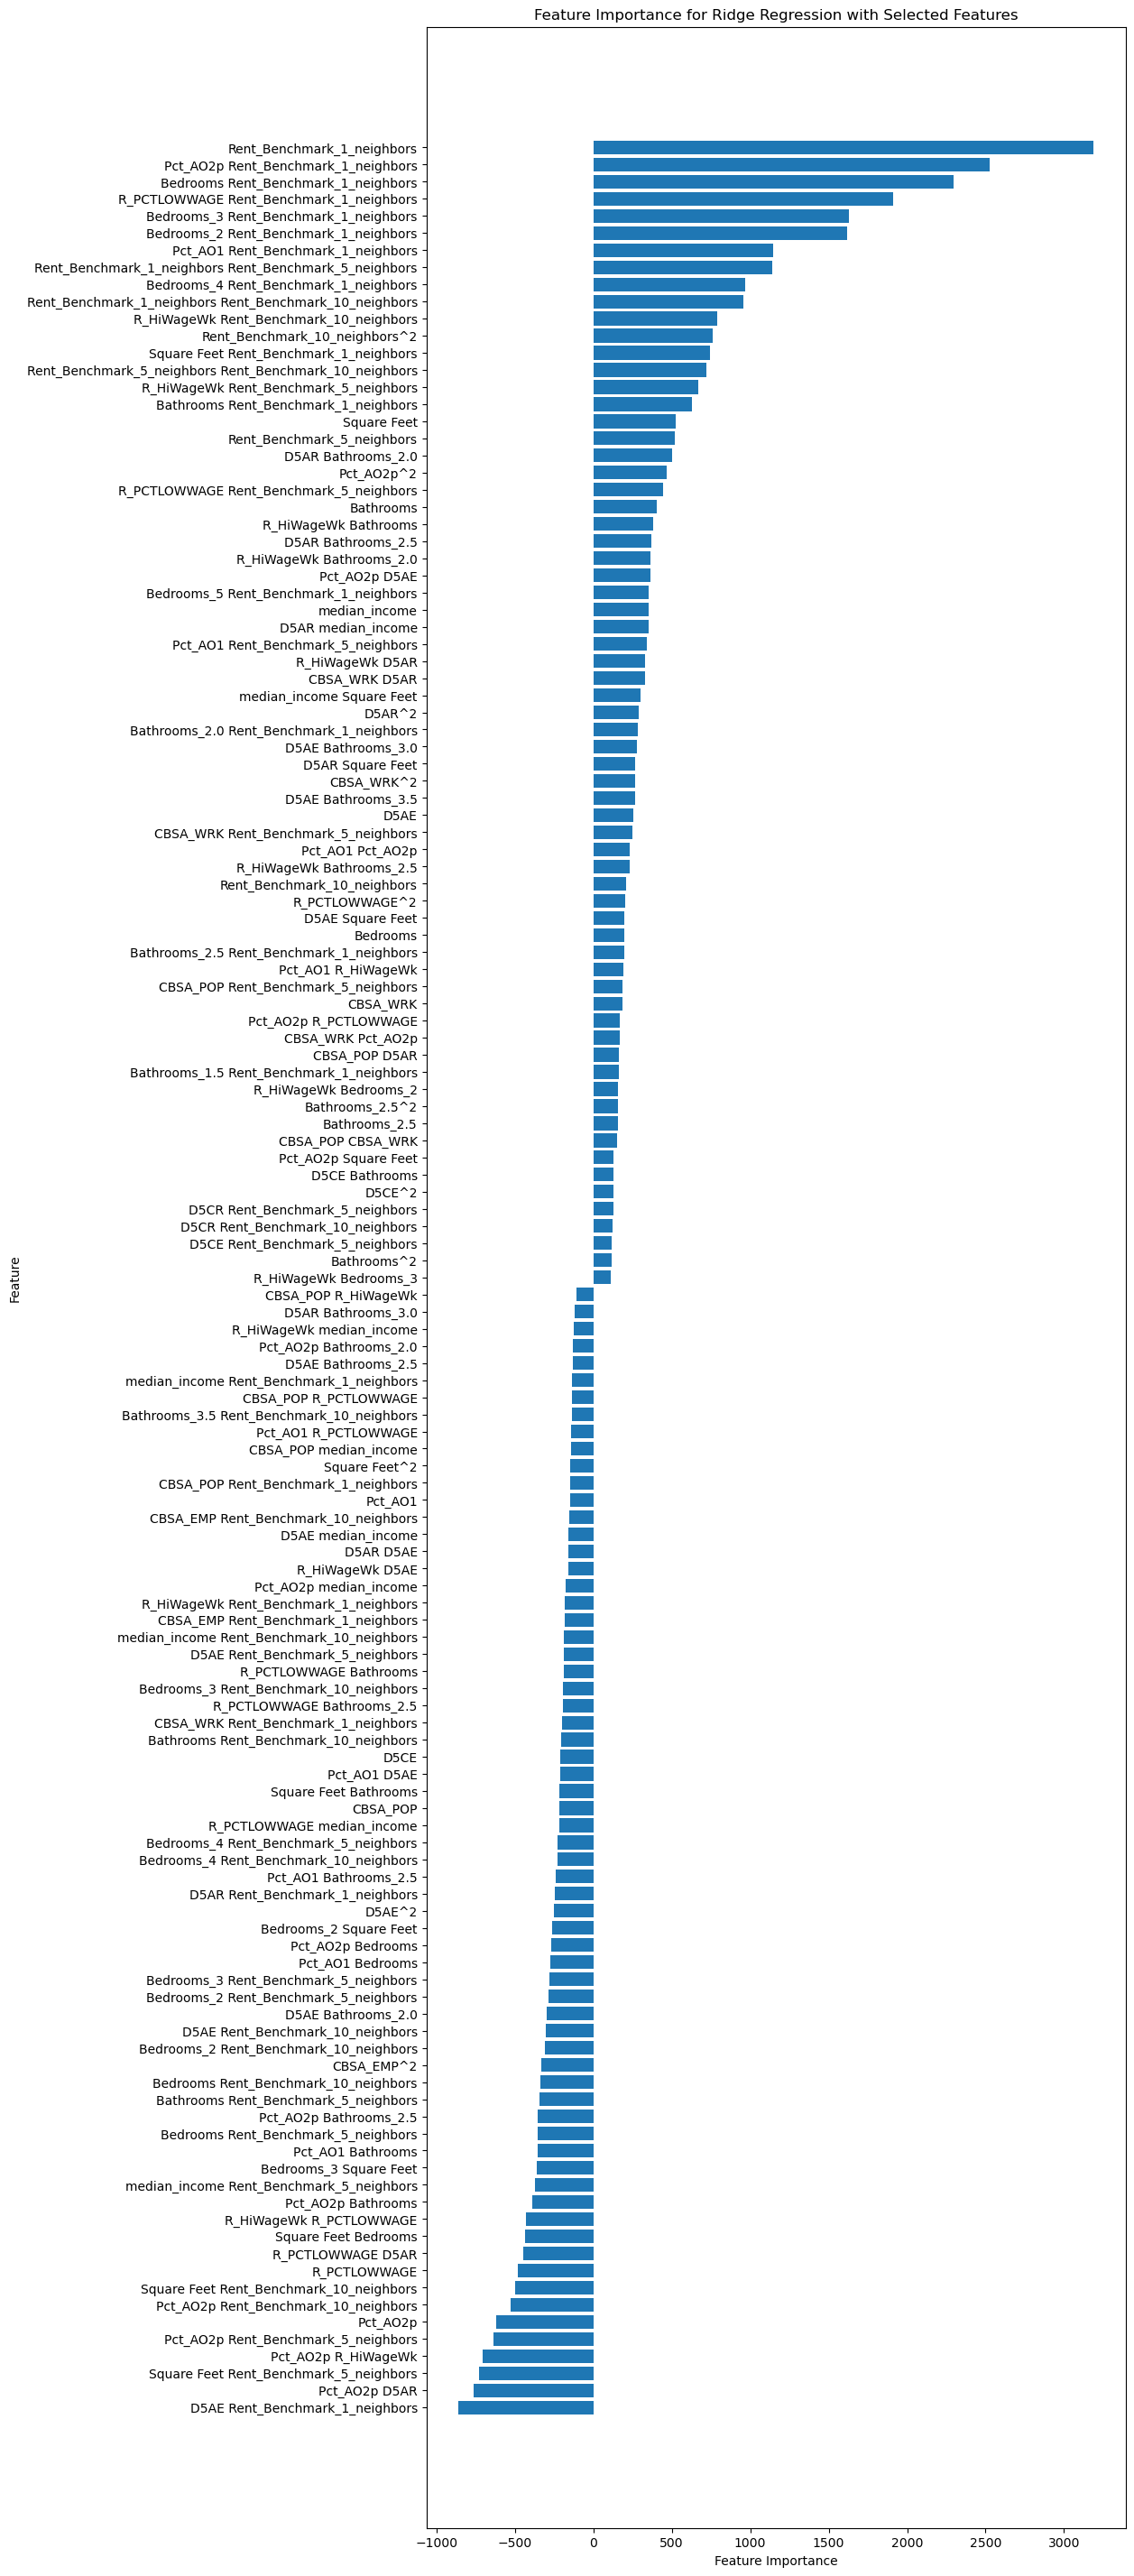

In [313]:

# Plot the number of features vs. cross-validation scores
plt.figure(figsize=(10, 6))
plt.title('Recursive Feature Elimination with Cross-Validation')
plt.xlabel('Number of features selected')
plt.ylabel('Cross-validation score (R^2)')
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

# Get the selected features mask
selected_features_mask = rfecv.support_

# Get the feature names
feature_names = poly.get_feature_names_out(potential_features)

# Get the selected features
selected_features = [feature for feature, selected in zip(feature_names, selected_features_mask) if selected]

# Print the selected features
print("Selected features:", selected_features)

# Transform the training and test sets to the optimal feature set
X_train_selected = rfecv.transform(X_train_poly)
X_test_selected = rfecv.transform(X_test_poly)

# Refit the model using the selected features
ridge.fit(X_train_selected, y_train)

# Evaluate the model
train_score = ridge.score(X_train_selected, y_train)
test_score = ridge.score(X_test_selected, y_test)

print("Train R^2 score with selected features: {:.4f}".format(train_score))
print("Test R^2 score with selected features: {:.4f}".format(test_score))

feature_importances = ridge.coef_

# Create a DataFrame for the feature importances
importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Print the feature importances
print(importance_df)

# Visualize the feature importances
plt.figure(figsize=(10, 36))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Ridge Regression with Selected Features')
plt.gca().invert_yaxis()
plt.show()

In [325]:

# Generate polynomial features for the entire dataset
X_scaled = scaler.transform(clean_df[potential_features])
X_poly = poly.transform(X_scaled)

# Select important features for the entire dataset
X_selected = rfecv.transform(X_poly)

# Create a new DataFrame with the original index and selected features
selected_feature_df = pd.DataFrame(X_selected, index=clean_df.index, columns=selected_features)

# Concatenate the new features with the original DataFrame
full_df = pd.concat([clean_df, selected_feature_df], axis=1)

# Display the new DataFrame
display(full_df)

,Property ID,Address,CBSA_POP,CBSA_EMP,CBSA_WRK,Pct_AO1,Pct_AO2p,R_HiWageWk,R_PCTLOWWAGE,D5AR,...,Bedrooms Rent_Benchmark_5_neighbors,Bedrooms Rent_Benchmark_10_neighbors,Bathrooms^2,Bathrooms Rent_Benchmark_1_neighbors,Bathrooms Rent_Benchmark_5_neighbors,Bathrooms Rent_Benchmark_10_neighbors,Rent_Benchmark_1_neighbors Rent_Benchmark_5_neighbors,Rent_Benchmark_1_neighbors Rent_Benchmark_10_neighbors,Rent_Benchmark_5_neighbors Rent_Benchmark_10_neighbors,Rent_Benchmark_10_neighbors^2
0,191142853,1833 W Quinn Rd Unit B,92778.0,37571.0,39000.0,0.206897,0.793103,140.0,0.300000,10154.0,...,0.031701,0.042572,0.00,0.000000,0.000000,0.000000,0.003496,0.004695,0.005398,0.007250
1,191136919,1821 W Quinn Rd Unit A,92778.0,37571.0,39000.0,0.206897,0.793103,140.0,0.300000,10154.0,...,0.032068,0.042572,0.00,0.000000,0.000000,0.000000,0.003874,0.005143,0.005461,0.007250
2,191143510,315 W 19th St Unit 315 1/2,142968.0,65164.0,62356.0,0.460123,0.539877,98.0,0.311429,24117.0,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.003714,0.004383,0.010491,0.012379
3,190233216,889 Iona St,142968.0,65164.0,62356.0,0.309917,0.667355,115.0,0.319608,20876.0,...,0.060018,0.058591,0.36,0.061450,0.072021,0.070309,0.012294,0.012001,0.014066,0.013732
13,165404221,540 E 6th N,26433.0,5731.0,8723.0,0.545299,0.432479,102.0,0.269767,2106.0,...,0.026147,0.031982,0.00,0.000000,0.000000,0.000000,0.011261,0.013774,0.013380,0.016365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23637,48513902,212 E Bandera Rd,2426204.0,979988.0,1019742.0,0.326460,0.673540,191.0,0.203474,53912.0,...,0.198661,0.164332,0.16,0.211134,0.158929,0.131466,0.209721,0.173481,0.130586,0.108021
23638,59363954,164 Autumn Rdg,2426204.0,979988.0,1019742.0,0.534789,0.427012,329.0,0.244228,46556.0,...,0.288063,0.244879,0.16,0.131303,0.153633,0.130602,0.126078,0.107177,0.125405,0.106606
23643,48510207,106 Cibolo Oak Ln,2426204.0,979988.0,1019742.0,0.328859,0.647651,249.0,0.198000,35186.0,...,0.186893,0.163253,0.16,0.072479,0.149515,0.130602,0.067729,0.059162,0.122043,0.106606
23647,48788695,10046 Saxet Dr,2426204.0,979988.0,1019742.0,0.176991,0.802360,730.0,0.136445,61777.0,...,0.178435,0.174958,0.16,0.146008,0.142748,0.139967,0.130265,0.127727,0.124875,0.122441


In [335]:
selected_features = selected_feature_df.columns.tolist()

Linear Regression: Mean R^2 = 0.9734, Std = 0.0061
Ridge: Mean R^2 = 0.9726, Std = 0.0072
Lasso: Mean R^2 = 0.9636, Std = 0.0093


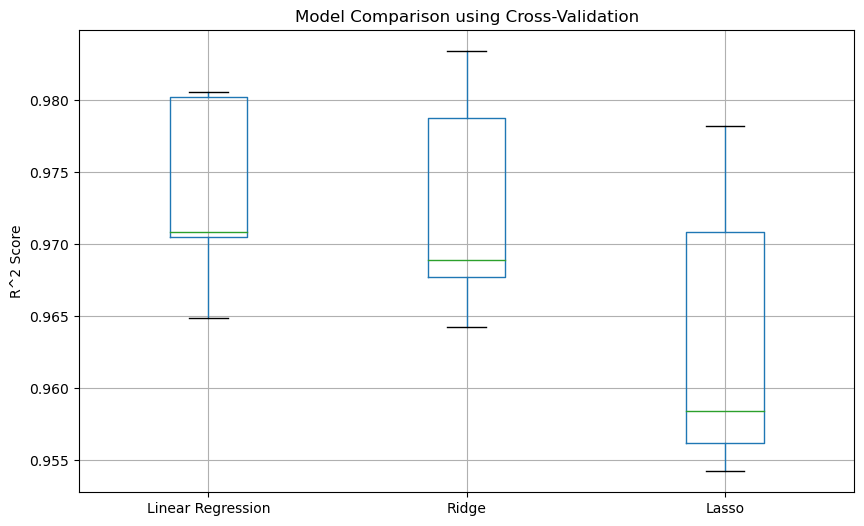

Best Model: Linear Regression
Test MAE: 86.0432
Test R^2: 0.9746


In [342]:
from sklearn.model_selection import cross_val_score


X_train_val, X_test, y_train_val, y_test = train_test_split(selected_feature_df, clean_df[[target]], train_size=0.8, random_state=27)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.8, random_state=27)


models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    # 'Random Forest': RandomForestRegressor(n_estimators=100, random_state=27)
}

results = {}

for model_name, model in models.items(): 
    scores = cross_val_score(model, X_train, y_train, scoring = 'r2')
    results[model_name] = scores
    print(f"{model_name}: Mean R^2 = {scores.mean():.4f}, Std = {scores.std():.4f}")

results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
results_df.boxplot()
plt.title('Model Comparison using Cross-Validation')
plt.ylabel('R^2 Score')
plt.show()

# Optionally, train the best model on the combined training and validation set and evaluate on the test set
best_model_name = max(results, key=lambda k: results[k].mean())
best_model = models[best_model_name]
best_model.fit(X_train_val, y_train_val)

# Evaluate on the test set
y_test_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Best Model: {best_model_name}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R^2: {test_r2:.4f}")

## Because Linear Regression is best, we do not need to have a validation datset for fine tuning

In [345]:
#Check against validation Dataset

X_train, X_test, y_train, y_test = train_test_split(selected_feature_df, clean_df[[target]], train_size=0.9, random_state=27)


linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

linear_model.predict(X_test)

LinearRegression()

Mean Absolute Error: 82.0653
R^2 Score: 0.9766


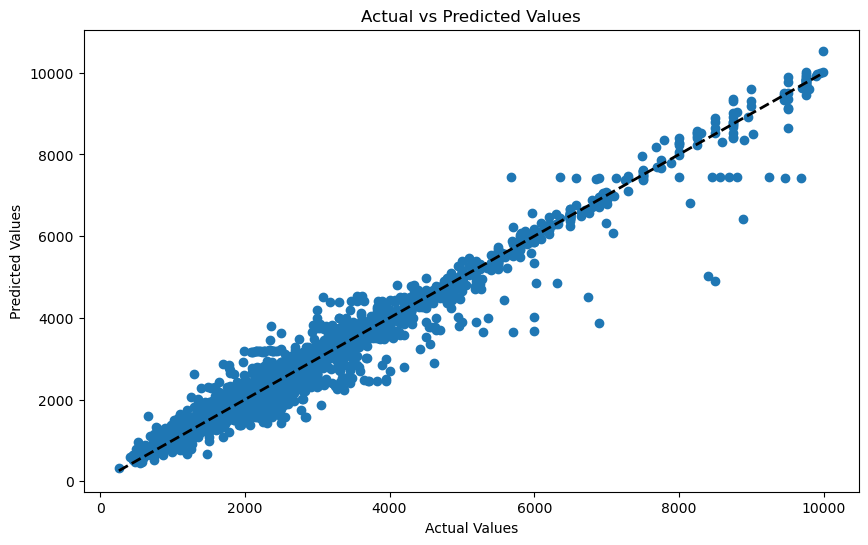

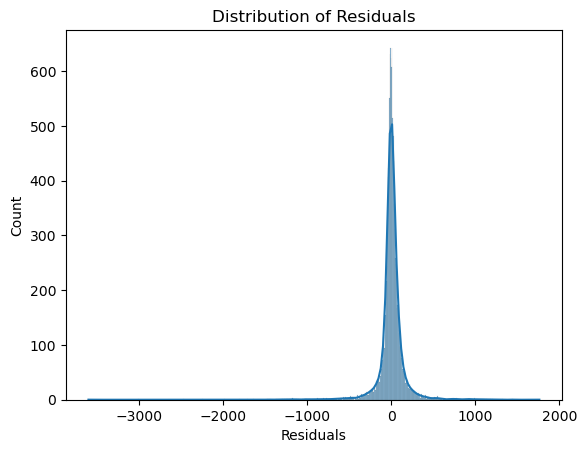

,Property ID,Address,CBSA_POP,CBSA_EMP,CBSA_WRK,Pct_AO1,Pct_AO2p,R_HiWageWk,R_PCTLOWWAGE,D5AR,...,Bathrooms_3.0,Bathrooms_3.5,Square Feet,Bedrooms,Bathrooms,Rent_Benchmark_1_neighbors,Rent_Benchmark_5_neighbors,Rent_Benchmark_10_neighbors,Rent,Predicted_Rent
0,191142853,1833 W Quinn Rd Unit B,92778.0,37571.0,39000.0,0.206897,0.793103,140.0,0.300000,10154.0,...,0.0,0.0,1080.0,3,1.0,1000.0,1025.0,1305.0,1000.0,1035.896195
1,191136919,1821 W Quinn Rd Unit A,92778.0,37571.0,39000.0,0.206897,0.793103,140.0,0.300000,10154.0,...,0.0,0.0,1080.0,3,1.0,1050.0,1030.0,1305.0,1050.0,1091.663527
2,191143510,315 W 19th St Unit 315 1/2,142968.0,65164.0,62356.0,0.460123,0.539877,98.0,0.311429,24117.0,...,0.0,0.0,500.0,1,1.0,850.0,1235.0,1492.4,850.0,878.854328
3,190233216,889 Iona St,142968.0,65164.0,62356.0,0.309917,0.667355,115.0,0.319608,20876.0,...,0.0,0.0,1375.0,3,2.5,1450.0,1410.0,1534.9,1450.0,1359.501792
13,165404221,540 E 6th N,26433.0,5731.0,8723.0,0.545299,0.432479,102.0,0.269767,2106.0,...,0.0,0.0,890.0,2,1.0,1500.0,1305.0,1612.0,1500.0,1486.006007


In [346]:

# Extract features and target variable
X = selected_feature_df
y = clean_df[target]

# Initialize and train the Linear Regression model on the entire dataset
model = LinearRegression()
model.fit(X, y)

# Make predictions on the entire dataset
predictions = model.predict(X)

# Add predictions to the original DataFrame
clean_df['Predicted_Rent'] = predictions

# Evaluate the model
mae = mean_absolute_error(y, predictions)
r2 = r2_score(y, predictions)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Optionally, visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()

# Optionally, visualize residuals
residuals = predictions - y
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

# Display the DataFrame with the predictions
display(clean_df.head())


In [347]:
display(clean_df)

,Property ID,Address,CBSA_POP,CBSA_EMP,CBSA_WRK,Pct_AO1,Pct_AO2p,R_HiWageWk,R_PCTLOWWAGE,D5AR,...,Bathrooms_3.0,Bathrooms_3.5,Square Feet,Bedrooms,Bathrooms,Rent_Benchmark_1_neighbors,Rent_Benchmark_5_neighbors,Rent_Benchmark_10_neighbors,Rent,Predicted_Rent
0,191142853,1833 W Quinn Rd Unit B,92778.0,37571.0,39000.0,0.206897,0.793103,140.0,0.300000,10154.0,...,0.0,0.0,1080.0,3,1.0,1000.0,1025.0,1305.0,1000.0,1035.896195
1,191136919,1821 W Quinn Rd Unit A,92778.0,37571.0,39000.0,0.206897,0.793103,140.0,0.300000,10154.0,...,0.0,0.0,1080.0,3,1.0,1050.0,1030.0,1305.0,1050.0,1091.663527
2,191143510,315 W 19th St Unit 315 1/2,142968.0,65164.0,62356.0,0.460123,0.539877,98.0,0.311429,24117.0,...,0.0,0.0,500.0,1,1.0,850.0,1235.0,1492.4,850.0,878.854328
3,190233216,889 Iona St,142968.0,65164.0,62356.0,0.309917,0.667355,115.0,0.319608,20876.0,...,0.0,0.0,1375.0,3,2.5,1450.0,1410.0,1534.9,1450.0,1359.501792
13,165404221,540 E 6th N,26433.0,5731.0,8723.0,0.545299,0.432479,102.0,0.269767,2106.0,...,0.0,0.0,890.0,2,1.0,1500.0,1305.0,1612.0,1500.0,1486.006007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23637,48513902,212 E Bandera Rd,2426204.0,979988.0,1019742.0,0.326460,0.673540,191.0,0.203474,53912.0,...,0.0,0.0,2188.0,3,2.0,5500.0,3295.0,3052.5,5500.0,5636.223553
23638,59363954,164 Autumn Rdg,2426204.0,979988.0,1019742.0,0.534789,0.427012,329.0,0.244228,46556.0,...,0.0,0.0,2392.0,4,2.0,3600.0,3205.0,3037.0,3600.0,3585.324210
23643,48510207,106 Cibolo Oak Ln,2426204.0,979988.0,1019742.0,0.328859,0.647651,249.0,0.198000,35186.0,...,0.0,0.0,1352.0,3,2.0,2200.0,3135.0,3037.0,2200.0,2124.535901
23647,48788695,10046 Saxet Dr,2426204.0,979988.0,1019742.0,0.176991,0.802360,730.0,0.136445,61777.0,...,0.0,0.0,2771.0,3,2.0,3950.0,3020.0,3205.0,3950.0,3878.832539
